# Melスペクトログラム作成ノートブック

このノートブックでは、`train.csv`の全filenameに対して以下の処理を実施します。

- 各音声ファイルを000_edaと同じパラメータでSTFTし、2.5秒ずつずらしながら5秒毎に切り取ります（区間5秒未満はzero padding）。
- Melスペクトログラムを計算し、正規化した上で`data/train_melspectrogram/{filename.replace('.ogg', '')}/slice_id.npy`として保存します。

In [1]:
import sys

import numpy as np
import polars as pl
import librosa
import librosa.display
import matplotlib.pyplot as plt

from IPython.lib.display import Audio
from tqdm import tqdm
import os
from pathlib import Path

In [2]:
train = pl.read_csv("./data/train.csv", null_values={"latitude": "None", "longitude": "None"}, infer_schema_length=10_0000)
filenames = train["filename"].to_list()
filenames

['1139490/CSA36385.ogg',
 '1139490/CSA36389.ogg',
 '1192948/CSA36358.ogg',
 '1192948/CSA36366.ogg',
 '1192948/CSA36373.ogg',
 '1192948/CSA36388.ogg',
 '1194042/CSA18783.ogg',
 '1194042/CSA18794.ogg',
 '1194042/CSA18802.ogg',
 '126247/XC941297.ogg',
 '126247/iNat1109254.ogg',
 '126247/iNat146584.ogg',
 '126247/iNat320679.ogg',
 '126247/iNat888527.ogg',
 '126247/iNat888729.ogg',
 '1346504/CSA18784.ogg',
 '1346504/CSA18791.ogg',
 '1346504/CSA18792.ogg',
 '1346504/CSA18793.ogg',
 '1346504/CSA18803.ogg',
 '134933/XC941298.ogg',
 '134933/iNat1108984.ogg',
 '134933/iNat1160199.ogg',
 '134933/iNat859408.ogg',
 '135045/iNat1122209.ogg',
 '135045/iNat1207345.ogg',
 '135045/iNat1207347.ogg',
 '135045/iNat1208549.ogg',
 '135045/iNat1208550.ogg',
 '135045/iNat1208551.ogg',
 '135045/iNat1208552.ogg',
 '135045/iNat1208572.ogg',
 '135045/iNat327127.ogg',
 '135045/iNat48803.ogg',
 '1462711/CSA36371.ogg',
 '1462711/CSA36379.ogg',
 '1462711/CSA36390.ogg',
 '1462737/CSA36341.ogg',
 '1462737/CSA36369.ogg',

In [3]:
SR = 32_000
N_FFT      = 1024
HOP_LENGTH = 512
N_MELS     = 128
FMIN       = 50
FMAX       = 14000
SLICE_SECONDS = 5.0
SLICE_SHIFT = 2.5

def save_melspectrogram_slices(filename):
    y, _ = librosa.load(filename, sr=SR)
    duration = librosa.get_duration(y=y, sr=SR)
    output_dir = Path("./data/train_melspectrograms") / Path(filename).stem
    os.makedirs(output_dir, exist_ok=True)
    slice_idx = 0
    start_sec = 0.0
    while start_sec < duration:
        end_sec = start_sec + SLICE_SECONDS
        start_sample = int(start_sec * SR)
        end_sample = int(end_sec * SR)
        y_slice = y[start_sample:end_sample]
        if len(y_slice) < int(SLICE_SECONDS * SR):
            y_slice = np.pad(y_slice, (0, int(SLICE_SECONDS * SR) - len(y_slice)))
        mel = librosa.feature.melspectrogram(
            y=y_slice,
            sr=SR,
            n_fft=N_FFT,
            hop_length=HOP_LENGTH,
            n_mels=N_MELS,
            fmin=FMIN,
            fmax=FMAX,
            power=2.0,
            pad_mode="reflect",
            norm='slaney',
            htk=True,
            center=True,
        )
        mel_db = librosa.power_to_db(mel, ref=np.max)
        mel_norm = (mel_db - mel_db.min()) / (mel_db.max() - mel_db.min() + 1e-9)
        output_path = output_dir / f"{slice_idx}.npy"
        np.save(output_path, mel_norm.astype(np.float32))
        slice_idx += 1
        start_sec += SLICE_SHIFT

In [4]:
import concurrent.futures

# Define the number of workers (adjust based on your CPU cores)
num_workers = os.cpu_count() // 2  # Using half of available CPU cores

def process_file(filename):
    file_path = Path("./data/train_audio") / filename
    return save_melspectrogram_slices(file_path)

# Create a partial function if save_melspectrogram_slices needs additional parameters
# process_func = partial(save_melspectrogram_slices, additional_param=value)

# Use ProcessPoolExecutor for parallel processing
with concurrent.futures.ProcessPoolExecutor(max_workers=num_workers) as executor:
    # Convert tqdm to work with parallel processing
    list(tqdm(executor.map(process_file, filenames), total=len(filenames)))

100%|█████████████████████████████████████████████████████████████████| 28564/28564 [4:08:36<00:00,  1.91it/s]


## 実行完了

生成したmelspectrogramデータのサンプル例を以下で確認できます。

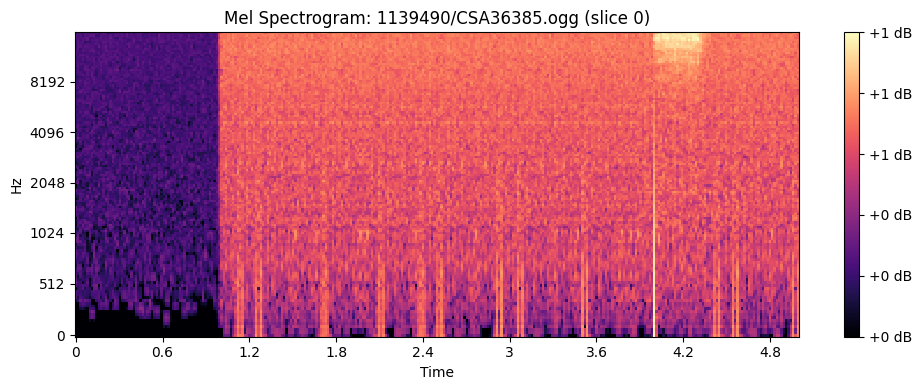

In [5]:
sample_file = filenames[0]
mel_dir = Path("data/train_melspectrograms") / Path(sample_file).stem
sample_mel_path = sorted(mel_dir.glob("*.npy"))[0]
mel_data = np.load(sample_mel_path)

y, sr = librosa.load(f"./data/train_audio/{sample_file}", sr=32_000)
display(Audio(y, rate=sr, autoplay=False))

plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_data, sr=SR, hop_length=HOP_LENGTH, x_axis='time', y_axis='mel')
plt.colorbar(format="%+2.0f dB")
plt.title(f"Mel Spectrogram: {sample_file} (slice 0)")
plt.tight_layout()
plt.show()

In [6]:
mel_root = Path("./data/train_melspectrograms")

In [9]:
all_melspectrograms = {}

In [11]:
for filename in tqdm(filenames):
    mel_dir = mel_root / Path(filename).stem

    slice_melspectrograms = {}

    for slice_file in mel_dir.glob("*.npy"):
        slice_id = int(slice_file.stem)
        mel_data = np.load(slice_file)
        slice_melspectrograms[slice_id] = mel_data

    all_melspectrograms[filename] = slice_melspectrograms

100%|███████████████████████████████████████████████████████████████████| 28564/28564 [07:19<00:00, 64.93it/s]


In [13]:
all_melspectrograms.keys()

dict_keys(['1139490/CSA36385.ogg', '1139490/CSA36389.ogg', '1192948/CSA36358.ogg', '1192948/CSA36366.ogg', '1192948/CSA36373.ogg', '1192948/CSA36388.ogg', '1194042/CSA18783.ogg', '1194042/CSA18794.ogg', '1194042/CSA18802.ogg', '126247/XC941297.ogg', '126247/iNat1109254.ogg', '126247/iNat146584.ogg', '126247/iNat320679.ogg', '126247/iNat888527.ogg', '126247/iNat888729.ogg', '1346504/CSA18784.ogg', '1346504/CSA18791.ogg', '1346504/CSA18792.ogg', '1346504/CSA18793.ogg', '1346504/CSA18803.ogg', '134933/XC941298.ogg', '134933/iNat1108984.ogg', '134933/iNat1160199.ogg', '134933/iNat859408.ogg', '135045/iNat1122209.ogg', '135045/iNat1207345.ogg', '135045/iNat1207347.ogg', '135045/iNat1208549.ogg', '135045/iNat1208550.ogg', '135045/iNat1208551.ogg', '135045/iNat1208552.ogg', '135045/iNat1208572.ogg', '135045/iNat327127.ogg', '135045/iNat48803.ogg', '1462711/CSA36371.ogg', '1462711/CSA36379.ogg', '1462711/CSA36390.ogg', '1462737/CSA36341.ogg', '1462737/CSA36369.ogg', '1462737/CSA36380.ogg', '14

In [14]:
all_melspectrograms["ywcpar/iNat681523.ogg"].keys()

dict_keys([18, 16, 36, 11, 34, 41, 5, 45, 49, 42, 24, 9, 3, 23, 44, 27, 40, 8, 21, 37, 38, 47, 46, 15, 35, 30, 6, 2, 10, 14, 0, 29, 20, 13, 12, 28, 32, 39, 17, 19, 33, 26, 22, 4, 7, 25, 1, 43, 48, 31])

In [16]:
all_melspectrograms["ywcpar/iNat681523.ogg"][2]

array([[0.6198385 , 0.8779707 , 0.82684237, ..., 0.8561015 , 0.93455976,
        0.8367721 ],
       [0.8547554 , 0.8024082 , 0.7794363 , ..., 0.70740634, 0.72860014,
        0.6860229 ],
       [0.84307164, 0.7907245 , 0.7677525 , ..., 0.69572264, 0.71691644,
        0.6743392 ],
       ...,
       [0.14309275, 0.10739663, 0.14303458, ..., 0.11155653, 0.1053995 ,
        0.09751818],
       [0.1453541 , 0.08725024, 0.09025986, ..., 0.10554597, 0.08450233,
        0.07435682],
       [0.12796897, 0.0920667 , 0.14033282, ..., 0.0851711 , 0.11394617,
        0.05996079]], shape=(128, 313), dtype=float32)

In [18]:
def get_size(obj, seen=None):
    """Function to recursively calculate object memory size"""
    # Handle circular references
    if seen is None:
        seen = set()

    # If object ID already seen, return 0
    obj_id = id(obj)
    if obj_id in seen:
        return 0

    # Record this object as seen
    seen.add(obj_id)

    # Get basic size
    size = sys.getsizeof(obj)

    # For dictionaries, add size of keys and values
    if isinstance(obj, dict):
        size += sum(get_size(k, seen) + get_size(v, seen) for k, v in obj.items())
    # For lists, tuples, sets, add size of elements
    elif hasattr(obj, '__iter__') and not isinstance(obj, (str, bytes, bytearray)):
        size += sum(get_size(i, seen) for i in obj)

    return size

In [19]:
get_size(all_melspectrograms)

67104556826

In [20]:
67104556826 / 1024 / 1024 / 1024

62.495988631621